# Calculating LCOE of our Production temperature
In one example simulation, a doublet scenario was simulated for a timeframe of 30 years.

In [8]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('talk')

In [9]:
# import temperature time series
data = pd.read_csv('../data/Gruppe8_Produktion_100Ls.csv')
#data['T[C]'] = data['T[C]'] + 12.
data.head()

,t[d],dt[d],T[C]
0,0.115741,0.115741,130.64
1,5.189656,5.073916,130.61
2,10.263572,5.073916,130.59
3,15.337487,5.073916,130.57
4,20.411403,5.073916,130.55


The loaded data has three columns. First the continuous time, second the time step size, third the production temperature. The "data" comes from a production simulation of the geothermal reservoir.

(0, 30)

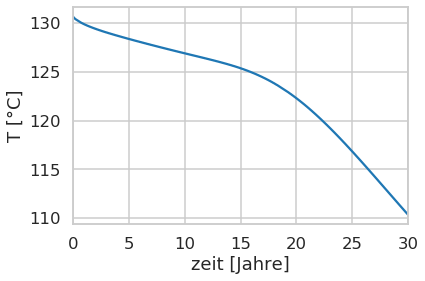

In [10]:
# plot time versus production temperature
#data.plot(x='t[d]', y='T[C]')
plt.plot(data['t[d]']/365.25, data['T[C]'])
plt.ylabel('T [°C]')
plt.xlabel('zeit [Jahre]')
plt.xlim([0,30])
#plt.savefig('prod_temp.svg',bbox_inches='tight');

## Thermal power
Let's calculate the thermal power with parameters:
* Q = 100 L/s  
* T_i = 40
* $\rho c_p$ = 4180*998

In [11]:
# parameters and thermal power calculation
cp = 4180 # J/(kg K)
rho = 998 # kg/m³
T_i = 40 # °C
Q = 0.1 # m³/s

P_th = Q * (rho*cp) * (data['T[C]'] - T_i) # W

(0, 30)

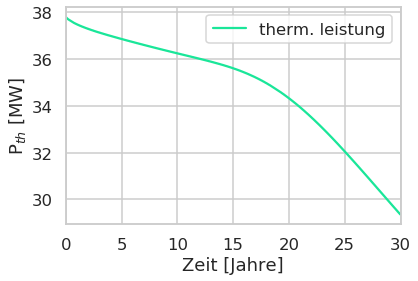

In [12]:
# thermal power
plt.plot(data['t[d]']/365.25, P_th*1e-6, c=(.1,.9,.6), label='therm. leistung')
plt.xlabel('Zeit [Jahre]')
plt.ylabel('P$_{th}$ [MW]')
plt.legend()
plt.xlim([0,30])
#plt.savefig('therm_leistung.svg', bbox_inches='tight');

## Conversion thermal power to electrical power
We use the general relation presented in Zarrouk and Moon (2014) to get from a reservoir enthalpy to a thermal efficiency, which we can then use to convert thermal power to electrical power. 
For a "general power plant", they state the relation:
$$\eta_c = 7.895 ln(h) - 45.651 $$

We transform h to the reservoir temperature by multiplying reservoir temperature $T_{res}$ with the specific heat capacity of water 4200 J/(kgK)

In [13]:
# estimation of "Reservoir Enthalpy"
h = cp*1e-3*(np.mean(data['T[C]'])+10) # Enthalpy in kJ/kg 
# + 10°C, as we say reservoir Temp is 10 °C higher than production Temp

eta_c = (7.895 * np.log(h) - 45.651) / 100 # efficiency
# wrong one from lecture
eta_c = (7.9705 * np.log(h) - 45.651) / 100 # efficiency

pl = 0.5e6 # parasitic load

P_el = P_th * eta_c # - pl
print("The Reservoir Enthalpy is {:.3f} kJ/kg".format(h))
print("The efficiency according to Zarrouk and Moon (2014) is {:.4f}.".format(eta_c))

The Reservoir Enthalpy is 557.670 kJ/kg
The efficiency according to Zarrouk and Moon (2014) is 0.0475.


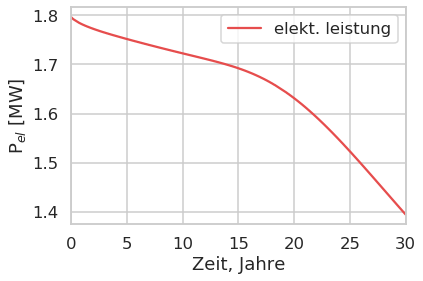

In [14]:
# plot electric power
plt.plot(data['t[d]']/365.25, P_el*1e-6, c=(.9,.3,.3), label='elekt. leistung')
plt.xlabel('Zeit, Jahre')
plt.ylabel('P$_{el}$ [MW]')
plt.legend()
plt.xlim([0,30])
plt.savefig('elektr_leistung.svg', bbox_inches='tight');

In [15]:
# calculate electrical energy produced
# Transfer days to hours of timesteps
dt = data['dt[d]'] * 24 

# Calculate electric energy produced at each timestep in kWh
Eel_100_step = P_el * dt * 1e-3

# Calculate thermal energy at each timestep in kWh
Eth_100 = P_th * dt * 1e-3

# Cummulative produced electric energy. Last values gives total produced energy
Eel = np.cumsum(Eel_100_step)
# Cummulative thermal energy produced
Eth = np.cumsum(Eth_100)


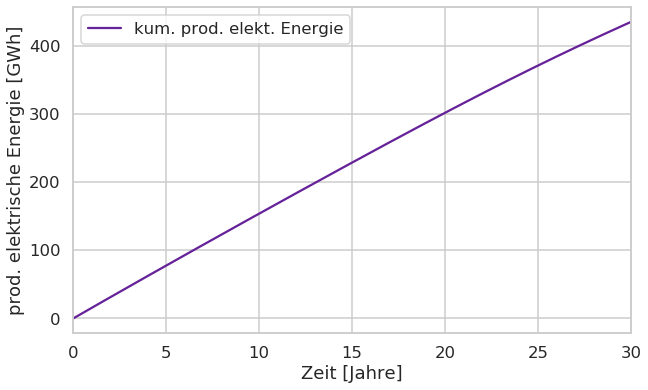

In [17]:
fig = plt.figure(figsize=[10,6])
plt.plot(data['t[d]']/365.25, Eel*1e-6, c='#662299', label='kum. prod. elekt. Energie')
plt.ylabel('prod. elektrische Energie [GWh]')
plt.xlabel('Zeit [Jahre]')
plt.legend()
plt.xlim([0,30]);
plt.savefig('cum_elektr_energie.svg', bbox_inches='tight')

In [40]:
Eth

0       1.050326e+05
1       4.707995e+06
2       9.309941e+06
3       1.391087e+07
4       1.851079e+07
            ...     
2200    9.131714e+09
2201    9.135222e+09
2202    9.138730e+09
2203    9.142237e+09
2204    9.144120e+09
Length: 2205, dtype: float64

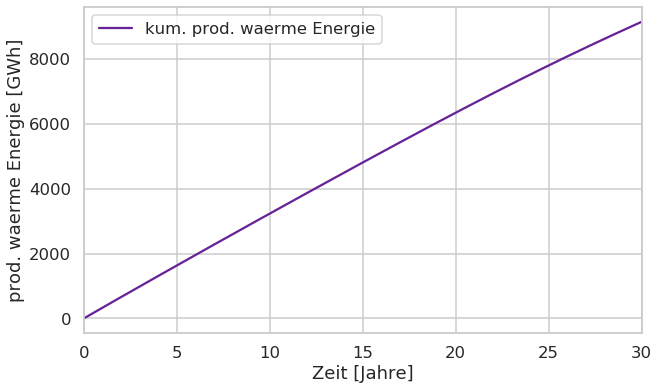

In [18]:
fig = plt.figure(figsize=[10,6])
plt.plot(data['t[d]']/365.25, Eth*1e-6, c='#662299', label='kum. prod. waerme Energie')
plt.ylabel('prod. waerme Energie [GWh]')
plt.xlabel('Zeit [Jahre]')
plt.legend()
plt.xlim([0,30]);
plt.savefig('cum_waerme_energie.svg', bbox_inches='tight')

## Well cost
Following a relationship given in Beckers et al. (2019), we estimate the cost of one well in $ using  
$$ C_well = 16.5 * MD **1.607 $$  
And now assume a drilling depth of 3500 m (Measured Depth, MD)

In [29]:
depth_well = 4000
C_well_getem = 16.5*depth_well**1.607 # 
S_well = 0.75 # 3 out of 4 wells are successful
G_wells = 2 # number of wells
x_ICW = 0.05 # indirect costs

C_well_drilling = C_well_getem / S_well # cost accounted for unsuccessfull wells

C_well_TPC = G_wells * (1 + x_ICW) * (C_well_drilling) # TPC cost

print("Well costs are {:.3f} M$".format(C_well_TPC*1e-6))

Well costs are 28.389 M$


## Surface pipe costs
Following Beckers et al. (2019), we estimate the cost of our surface pipe. We estimate to take about 800 m pipes per well.

In [30]:
m_per_well = 750

C_surface_pipe_TPC = 1.27 * 500 * m_per_well * G_wells
print("Surface pipe cost is {:.3f} M$".format(C_surface_pipe_TPC*1e-6))

Surface pipe cost is 0.952 M$


## Powerplant cost
Power plant costs are estimated using Beckers et al. (2019) formulations. For this, we first estimate the Utilization efficiency based on the production temperature (plot above). We first calculate it with the average temperature over the whole 30 years and see how this goes...

Ok, so we might have a 5 MWe Powerplant on average. Not bad, not bad. Now, we estimate its cost by using the equation given in in Beckers et al. (2019)
![image.png](Beckers_ccap_pp.png)

In [31]:
# average production temperature
T_prod_av = np.mean(data['T[C]'])
K3 = -1.45833e-3
K2 = 7.6875e-1
K1 = -1.34792e2
K0 = 1.0075e4
if T_prod_av <= 170:
    C_powerplant_TPC = np.mean(P_el)*1e-3 * (K3 * T_prod_av**3 + K2 * T_prod_av**2 + K1 * T_prod_av + K0)
elif T_prod_av > 170:
    C_powerplant_TPC = np.mean(P_el)*1e-3 * (2212.5 - 0.514*(T_prod_av - 170.))
# correct for lower capacities
C_pp_TPC = C_powerplant_TPC * ((np.mean(P_el)*1e-3)/15000)**-0.06

print("Powerplant cost with thermal efficieny by Zarouk is {} M$".format(C_pp_TPC*1e-6))

Powerplant cost with thermal efficieny by Zarouk is 4.544394297022433 M$


In [32]:
# powerplant cost for thermal powerplant
C_pph_TPC = 150 * np.mean(P_th*1e-3)
print("Powerplant cost for only direct-heat use is {} M$".format(C_pph_TPC*1e-6))

Powerplant cost for only direct-heat use is 5.219594562764625 M$


## Total capital cost
To get to the total capital cost, we sum everything up.

In [33]:
C_total_TPC = C_well_TPC + C_surface_pipe_TPC + C_pp_TPC
C_total_TPC_heat = C_well_TPC + C_surface_pipe_TPC + C_pph_TPC

print("We have a cost of about {:.3f} M$ whith an efficiency of {:.3f}.".format(*[np.mean(C_total_TPC)*1e-6],eta_c))
print("We have a cost of about {:.3f} M$ for a heat plant.".format(*[np.mean(C_total_TPC_heat)*1e-6]))

We have a cost of about 33.886 M$ whith an efficiency of 0.048.
We have a cost of about 34.561 M$ for a heat plant.


## LCOE
![image.png](lcoe_eq.png)  
* CRF = 0.1  
* Lifetime = 30 years  
* PV_d = 0.83  
* Capacity Factor = 0.9  
* TaxRate = 0.2

In [34]:
LCOE = (C_total_TPC * (0.1 * 30)) / (0.9*Eel.tail(1)*1e-3) * ((1-0.2*0.83)/(1-0.2))

In [35]:
print("The LCOE would be {:.2f} $ / MWh".format(LCOE.values[0]))

The LCOE would be 270.96 $ / MWh


In [36]:
LCOH = (C_total_TPC_heat * (0.1 * 30)) / (0.5*Eth.tail(1)*1e-3) * ((1-0.2*0.83)/(1-0.2))

In [37]:
print("The LCOH would be {:.2f} $ / MWh".format(LCOH.values[0]))

The LCOH would be 23.64 $ / MWh
